### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import glob
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten

### Load and concatenate data

In [53]:
data_dir = '/Users/deniseahishakiye/Desktop/StockMarketData'
data_files = glob.glob(data_dir + "/*.csv")
data_list = [pd.read_csv(file, index_col=None, header=0) for file in data_files]
combined_data = pd.concat(data_list, axis=0, ignore_index=True)

# Convert 'Close' to numeric and handle NaNs
combined_data['Close'] = pd.to_numeric(combined_data['Close'], errors='coerce')
combined_data.dropna(subset=['Close'], inplace=True)

# Handle missing values
combined_data.reset_index(drop=True, inplace=True)
combined_data.fillna(combined_data.mean(), inplace=True)


/var/folders/ps/qm7zf_j10ls8fhq9f8hk0l040000gn/T/ipykernel_2924/3334097746.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined_data.fillna(combined_data.mean(), inplace=True)


In [54]:
combined_data.head(10)

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,Company Name,Industry,ISIN Code
0,2002-02-18,BHARTI,EQ,0.00,51.90,51.90,43.50,44.70,44.35,46.00,10381190.0,4.775431e+13,61964.270982,6.503775e+06,0.626500,NaN,NaN,NaN
1,2002-02-19,BHARTI,EQ,44.35,45.15,45.15,41.30,41.35,41.70,42.58,3552660.0,1.512609e+13,61964.270982,1.741184e+06,0.490100,NaN,NaN,NaN
2,2002-02-20,BHARTI,EQ,41.70,40.60,42.80,40.25,41.20,41.25,41.56,2512964.0,1.044348e+13,61964.270982,1.315098e+06,0.502997,NaN,NaN,NaN
3,2002-02-21,BHARTI,EQ,41.25,42.85,43.40,42.15,42.20,42.40,42.76,1338196.0,5.722681e+12,61964.270982,4.859690e+05,0.363200,NaN,NaN,NaN
4,2002-02-22,BHARTI,EQ,42.40,42.65,43.60,41.10,43.35,43.30,42.75,811327.0,3.468413e+12,61964.270982,3.991330e+05,0.492000,NaN,NaN,NaN
5,2002-02-25,BHARTI,EQ,43.30,45.50,45.50,42.65,42.95,42.80,43.05,454151.0,1.955300e+12,61964.270982,2.377100e+05,0.523400,NaN,NaN,NaN
6,2002-02-26,BHARTI,EQ,42.80,43.15,44.20,42.90,43.70,43.60,43.48,894960.0,3.891165e+12,61964.270982,5.393390e+05,0.602600,NaN,NaN,NaN
7,2002-02-27,BHARTI,EQ,43.60,43.95,46.30,43.75,44.45,44.65,45.02,3271361.0,1.472882e+13,61964.270982,1.376980e+06,0.420900,NaN,NaN,NaN
8,2002-02-28,BHARTI,EQ,44.65,46.00,46.80,40.80,41.40,41.50,44.48,4429634.0,1.970277e+13,61964.270982,1.583183e+06,0.357400,NaN,NaN,NaN
9,2002-03-01,BHARTI,EQ,41.50,42.00,43.40,41.80,42.45,42.50,42.52,942785.0,4.008985e+12,61964.270982,4.734530e+05,0.502200,NaN,NaN,NaN


### Calculate the correlation matrix

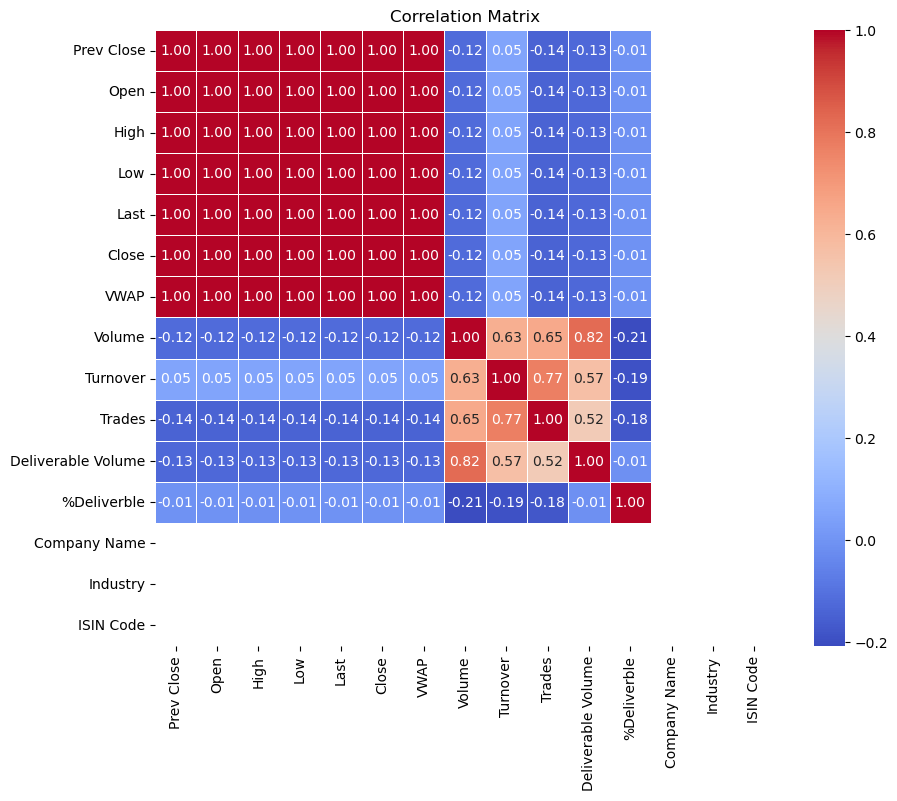

In [55]:
import seaborn as sns

correlation_matrix = combined_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [56]:
combined_data.shape

(470384, 18)

## Data Preprocessing

In [61]:
# Identify missing values
missing_values_mask = combined_data.isnull()

# Count the number of missing values in each column
missing_values_count = missing_values_mask.sum()

# Check for missing values using isna()
nan_mask = combined_data.isna()


# Print the missing values for null
print("\nMissing values for null:")
missing_values = combined_data[columns_with_missing_values.index].isnull().sum()
print(missing_values)

# Print the missing values for na
print("\nMissing values for nan:")
missing_values = combined_data[columns_with_missing_values.index].isna().sum()
print(missing_values)


Missing values for null:
Company Name    470384
Industry        470384
ISIN Code       470384
dtype: int64

Missing values for nan:
Company Name    470384
Industry        470384
ISIN Code       470384
dtype: int64


### Removing unnecessary columns, columns to close to close price we will consider below data

In [79]:
dataset=combined_data[['Symbol','Open', 'High', 'Low', 'Last','Close']]
dataset.head()

,Symbol,Open,High,Low,Last,Close
0,BHARTI,51.90,51.90,43.50,44.70,44.35
1,BHARTI,45.15,45.15,41.30,41.35,41.70
2,BHARTI,40.60,42.80,40.25,41.20,41.25
3,BHARTI,42.85,43.40,42.15,42.20,42.40
4,BHARTI,42.65,43.60,41.10,43.35,43.30


In [78]:
dataset.describe()

,Open,High,Low,Last,Close
count,470384.000000,470384.000000,470384.000000,470384.000000,470384.000000
mean,1267.759708,1286.581440,1247.488465,1266.388302,1266.554351
std,2585.256861,2619.646432,2546.618689,2581.389799,2582.138197
min,8.500000,9.750000,8.500000,9.100000,9.150000
25%,275.000000,279.500000,269.600000,274.400000,274.350000
50%,567.025000,576.900000,556.500000,567.000000,566.700000
75%,1243.312500,1263.000000,1221.650000,1242.900000,1242.400000
max,33399.950000,33480.000000,32468.100000,32849.000000,32861.950000


### Filter the dataset for the top 5 Stocks:

In [85]:
# Assuming 'performance_metric' column represents the performance of each Stocks
Stocks_performance = dataset.groupby('Symbol')['Close'].mean()
# Assuming 'performance_metric' column represents the performance of each Stocks
Stocks_performance = dataset.groupby('Symbol')['Close'].mean()
top_Stocks = Stocks_performance.nlargest(5).index
selected_Stocks_data = combined_data[dataset['Symbol'].isin(top_Stocks)]

In [86]:
selected_Stocks_data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,Company Name,Industry,ISIN Code
32589,2010-01-08,NESTLEIND,EQ,2512.95,2555.00,2575.0,2475.20,2476.0,2494.65,2529.81,648.0,1.639316e+11,61964.270982,438.0,0.6759,NaN,NaN,NaN
32590,2010-01-11,NESTLEIND,EQ,2494.65,2401.00,2515.0,2400.00,2500.0,2498.95,2494.44,825.0,2.057909e+11,61964.270982,638.0,0.7733,NaN,NaN,NaN
32591,2010-01-12,NESTLEIND,EQ,2498.95,2540.00,2540.0,2471.35,2505.0,2502.85,2485.22,68346.0,1.698549e+13,61964.270982,67695.0,0.9905,NaN,NaN,NaN
32592,2010-01-13,NESTLEIND,EQ,2502.85,2502.85,2540.0,2480.00,2489.8,2489.35,2491.94,1032.0,2.571682e+11,61964.270982,718.0,0.6957,NaN,NaN,NaN
32593,2010-01-14,NESTLEIND,EQ,2489.35,2535.00,2595.0,2470.00,2560.0,2568.20,2510.27,330361.0,8.292956e+13,61964.270982,329193.0,0.9965,NaN,NaN,NaN


### Data visualization for the to 5 performing Stocks from 2002-02-18 to 2021-04-30

/var/folders/ps/qm7zf_j10ls8fhq9f8hk0l040000gn/T/ipykernel_2924/705329124.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_Stocks_data['Date'] = pd.to_datetime(selected_Stocks_data['Date'])


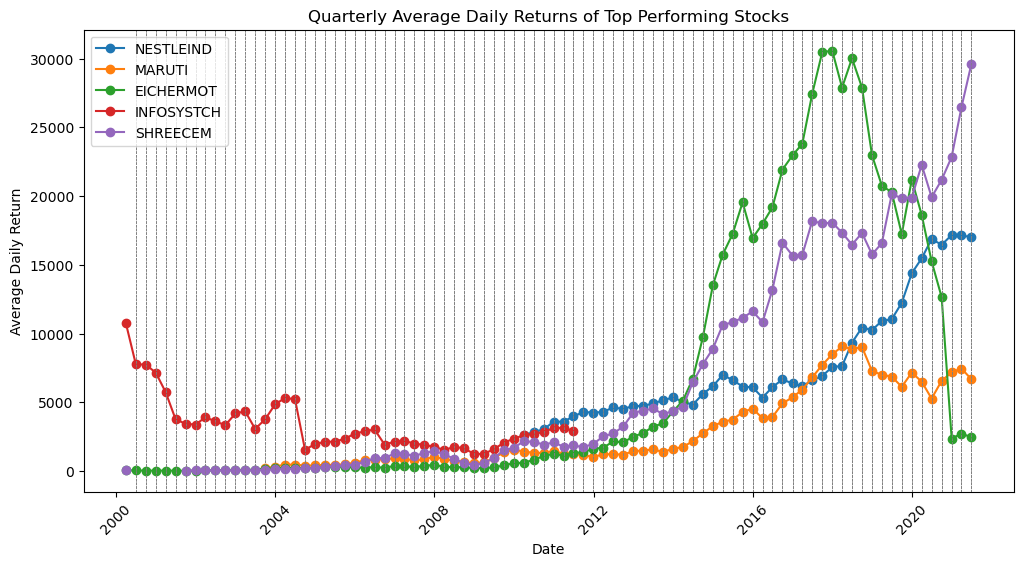

In [87]:
# Convert the date column to pandas datetime format
selected_Stocks_data['Date'] = pd.to_datetime(selected_Stocks_data['Date'])

plt.figure(figsize=(12, 6))

# Iterate over each Stocks symbol
for symbol in selected_Stocks_data['Symbol'].unique():
    Stocks_data = selected_Stocks_data[selected_Stocks_data['Symbol'] == symbol]

    # Resample the data to quarterly frequency
    quarterly_returns = Stocks_data.set_index('Date').resample('Q')['Close'].mean()

    # Fill missing quarters with NaN
    quarters = pd.date_range(start=quarterly_returns.index.min(), end=quarterly_returns.index.max(), freq='Q')
    quarterly_returns = quarterly_returns.reindex(quarters)

    # Plotting quarterly average daily returns
    plt.plot(quarterly_returns.index, quarterly_returns.values,marker='o', linestyle='-', label=symbol)

    # Add vertical lines at the boundaries of each quarter
    for quarter in quarters[1:]:
        plt.axvline(quarter, color='gray', linestyle='--', linewidth=0.5)

plt.title('Quarterly Average Daily Returns of Top Performing Stocks')
plt.xlabel('Date')
plt.ylabel('Average Daily Return')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Create a scaler for our dataset exclude the symbol column

In [95]:

dataset_final=dataset[['Open', 'High', 'Low', 'Last','Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset_final)

close_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the Close price
scaled_close = close_scaler.fit_transform(dataset_final[['Close']])

scaled_data[:, 3] = scaled_close.flatten()


### Prepare Data for Model

In [ ]:
X = []
Y = []
window_size = 100

for i in range(window_size, len(scaled_data) - window_size - 1):
    window_data = scaled_data[i-window_size:i]
    next_day_close_price = scaled_data[i + window_size, 3]  # Close price is at index 3
    X.append(window_data)
    Y.append(next_day_close_price)


# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

### Split data into training and testing sets

In [97]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.3, shuffle=True)

# Reshape data for the model
train_X = train_X.reshape(train_X.shape[0], 1, window_size, 5)
test_X = test_X.reshape(test_X.shape[0], 1, window_size, 5)
print('train_X shape: ', train_X.shape)
print('test_X shape: ', test_X.shape)

train_X shape:  (329128, 1, 100, 5)
test_X shape:  (141055, 1, 100, 5)


### Define the model

In [100]:
def create_model():
    model = tf.keras.Sequential()
    
    # CNN layers
    #model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, 100, 1)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, window_size, 5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    
    # LSTM layers
    model.add(Bidirectional(LSTM(units=100, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(units=100, return_sequences=False)))
    model.add(Dropout(0.5))
    
    # Dense layer
    model.add(Dense(1, activation='linear'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

    return model

# Call the function to create the model
model = create_model()

# Model training
history = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=20, batch_size=40, verbose=1, shuffle=True)

Epoch 1/20
8229/8229 [==============================] - 95s 11ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0137 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0104
Epoch 2/20
8229/8229 [==============================] - 86s 10ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0128 - val_loss: 9.9475e-04 - val_mse: 9.9475e-04 - val_mae: 0.0124
Epoch 3/20
8229/8229 [==============================] - 89s 11ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0121 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0113
Epoch 4/20
8229/8229 [==============================] - 90s 11ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0121 - val_loss: 9.1339e-04 - val_mse: 9.1339e-04 - val_mae: 0.0100
Epoch 5/20
8229/8229 [==============================] - 95s 12ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0120 - val_loss: 8.8640e-04 - val_mse: 8.8640e-04 - val_mae: 0.0096
Epoch 6/20
8229/8229 [==============================] - 90s 11ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0119 - val_loss: 8.6912e-04 

### Save and reload model

In [ ]:
model.save("model_lstm_cnn_final.h5")
loaded_model = tf.keras.models.load_model("./model_lstm_cnn_final.h5")


### Print the model summary

In [101]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDis  (None, None, 98, 64)     1024      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, None, 49, 64)     0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, None, 47, 128)    24704     
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, None, 23, 128)    0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, None, 21, 64)    

### Model evaluation

In [172]:
test_loss, test_mse, test_mae = model.evaluate(test_X, test_Y)

# Calculate RMSE
rmse = np.sqrt(test_mse)
# print('Test RMSE: ', rmse)

test_loss_percentage = test_loss * 100
test_mse_percentage = test_mse * 100
test_mae_percentage = test_mae * 100
rmse_percentage = rmse * 100

print('Test Loss (test_loss) Score: {:.2f}%'.format(test_loss_percentage))
print('Test MSE (test_mse) Score: {:.2f}%'.format(test_mse_percentage))
print('Test MAE (test_mae) Score: {:.2f}%'.format(test_mae_percentage))
print('Test RMSE (test_mae) Score: {:.2f}%'.format(rmse_percentage))


4408/4408 [==============================] - 15s 3ms/step - loss: 7.9952e-04 - mse: 7.9952e-04 - mae: 0.0100
Test Loss (test_loss) Score: 0.08%
Test MSE (test_mse) Score: 0.08%
Test MAE (test_mae) Score: 1.00%
Test RMSE (test_mae) Score: 2.83%


### RE-Evaluate model  Calculate R-squared (R2) score

In [122]:
from sklearn.metrics import r2_score

r2 = r2_score(test_Y_rescaled, predictions_rescaled)
r2_percentage = r2 * 100
print('R-squared (R2) Score: {:.2f}%'.format(r2_percentage))

R-squared (R2) Score: 87.28%


### Visualization of Predicted price  vs Original Price

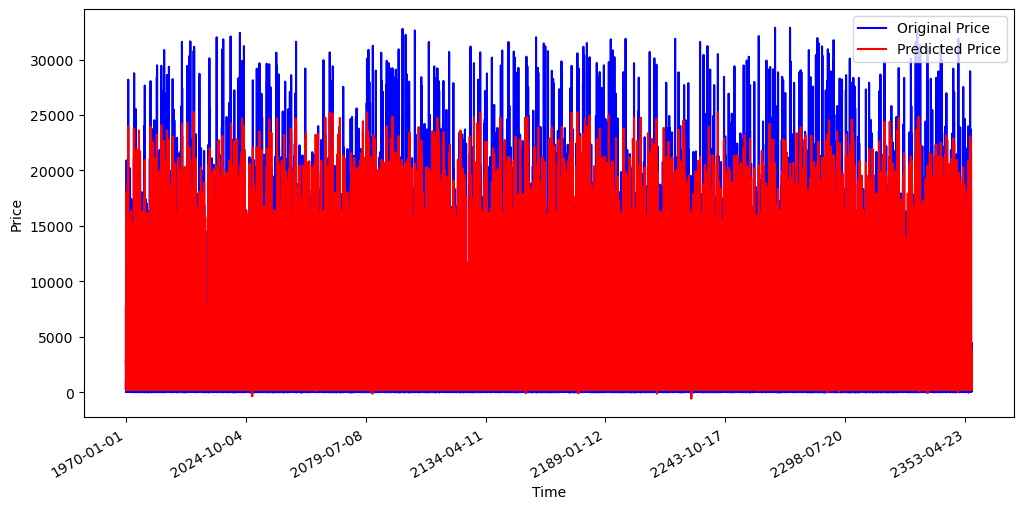

In [126]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a scaler for all data
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale all data
scaled_data = scaler.fit_transform(dataset_final)

# Create a separate scaler for the 'Close' price
close_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the Close price
scaled_close = close_scaler.fit_transform(dataset_final[['Close']])

# Replace the Close price in scaled_data with the scaled Close price
scaled_data[:, 3] = scaled_close.flatten()

# Assuming you've saved your scaler object for 'Close' price into a variable named 'close_scaler'
test_Y_rescaled = close_scaler.inverse_transform(test_Y.reshape(-1, 1))
predictions_rescaled = close_scaler.inverse_transform(predictions.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(test_Y_rescaled, 'b', label='Original Price')  # Close price
plt.plot(predictions_rescaled, 'r', label='Predicted Price')  # Close price

# Format the x-axis ticks with the desired date format
date_format = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().autofmt_xdate()

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


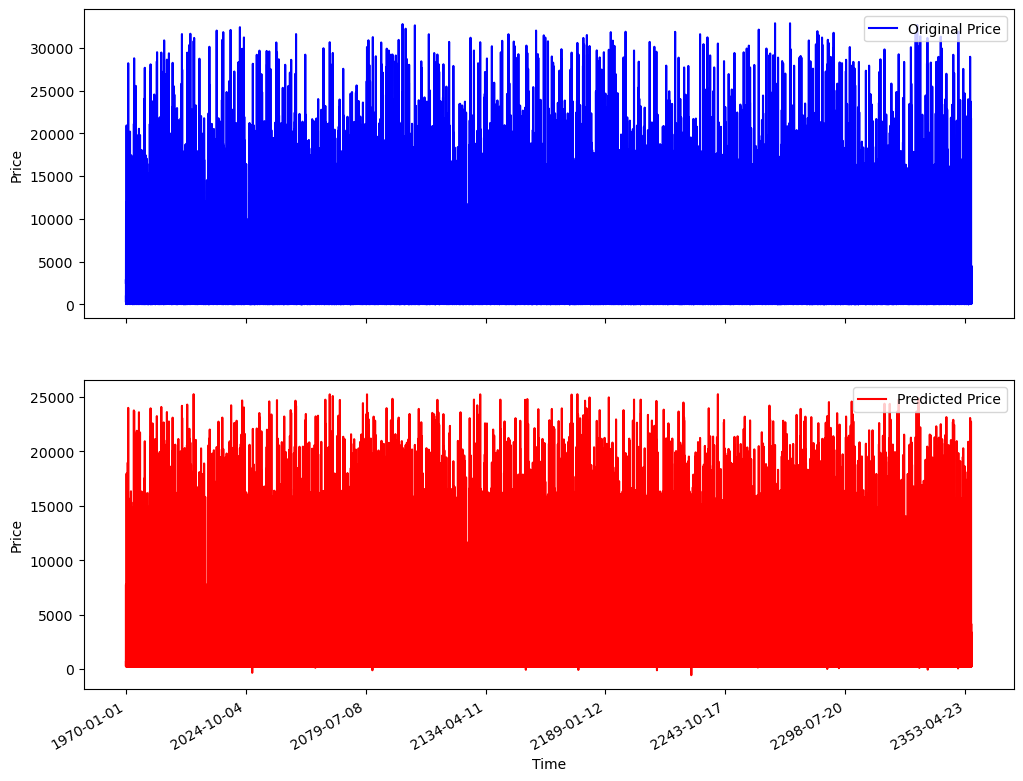

In [158]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a scaler for all data
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale all data
scaled_data = scaler.fit_transform(dataset_final)

# Create a separate scaler for the 'Close' price
close_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the Close price
scaled_close = close_scaler.fit_transform(dataset_final[['Close']])

# Replace the Close price in scaled_data with the scaled Close price
scaled_data[:, 3] = scaled_close.flatten()

# Assuming you've saved your scaler object for 'Close' price into a variable named 'close_scaler'
test_Y_rescaled = close_scaler.inverse_transform(test_Y.reshape(-1, 1))
predictions_rescaled = close_scaler.inverse_transform(predictions.reshape(-1, 1))

# Plot the original price and predicted price
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot the original price in the upper subplot
ax1.plot(test_Y_rescaled, 'b', label='Original Price')  # Close price
ax1.set_ylabel('Price')
ax1.legend()

# Plot the predicted price in the lower subplot
ax2.plot(predictions_rescaled, 'r', label='Predicted Price')  # Close price
ax2.set_xlabel('Time')
ax2.set_ylabel('Price')
ax2.legend()

# Format the x-axis ticks with the desired date format
date_format = mdates.DateFormatter('%Y-%m-%d')
ax2.xaxis.set_major_formatter(date_format)
plt.gcf().autofmt_xdate()

plt.show()
